##### Copyright 2019 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 베이지안 변환점(switchpoint) 분석

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/probability/examples/Bayesian_Switchpoint_Analysis"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/probability/examples/Bayesian_Switchpoint_Analysis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/probability/examples/Bayesian_Switchpoint_Analysis.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/probability/examples/Bayesian_Switchpoint_Analysis.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

이 노트북에서는 [pymc3 설명서](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters)의 베이지안 '변환점 분석' 예제를 다시 구현하고 확장합니다.

## 전제 조건

In [ ]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,8)
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd

## 데이터세트

데이터세트는 [여기](https://pymc-devs.github.io/pymc/tutorial.html#two-types-of-variables)에서 가져왔습니다. 이 예제 <a>floating around</a>의 다른 버전이 있지만, '누락된' 데이터가 있다는 점을 유의하세요. 이 경우 누락된 값을 대치해야 합니다. (그렇지 않으면 우도 함수가 정의되지 않으므로 모델이 초기 매개변수를 떠나지 않습니다.)

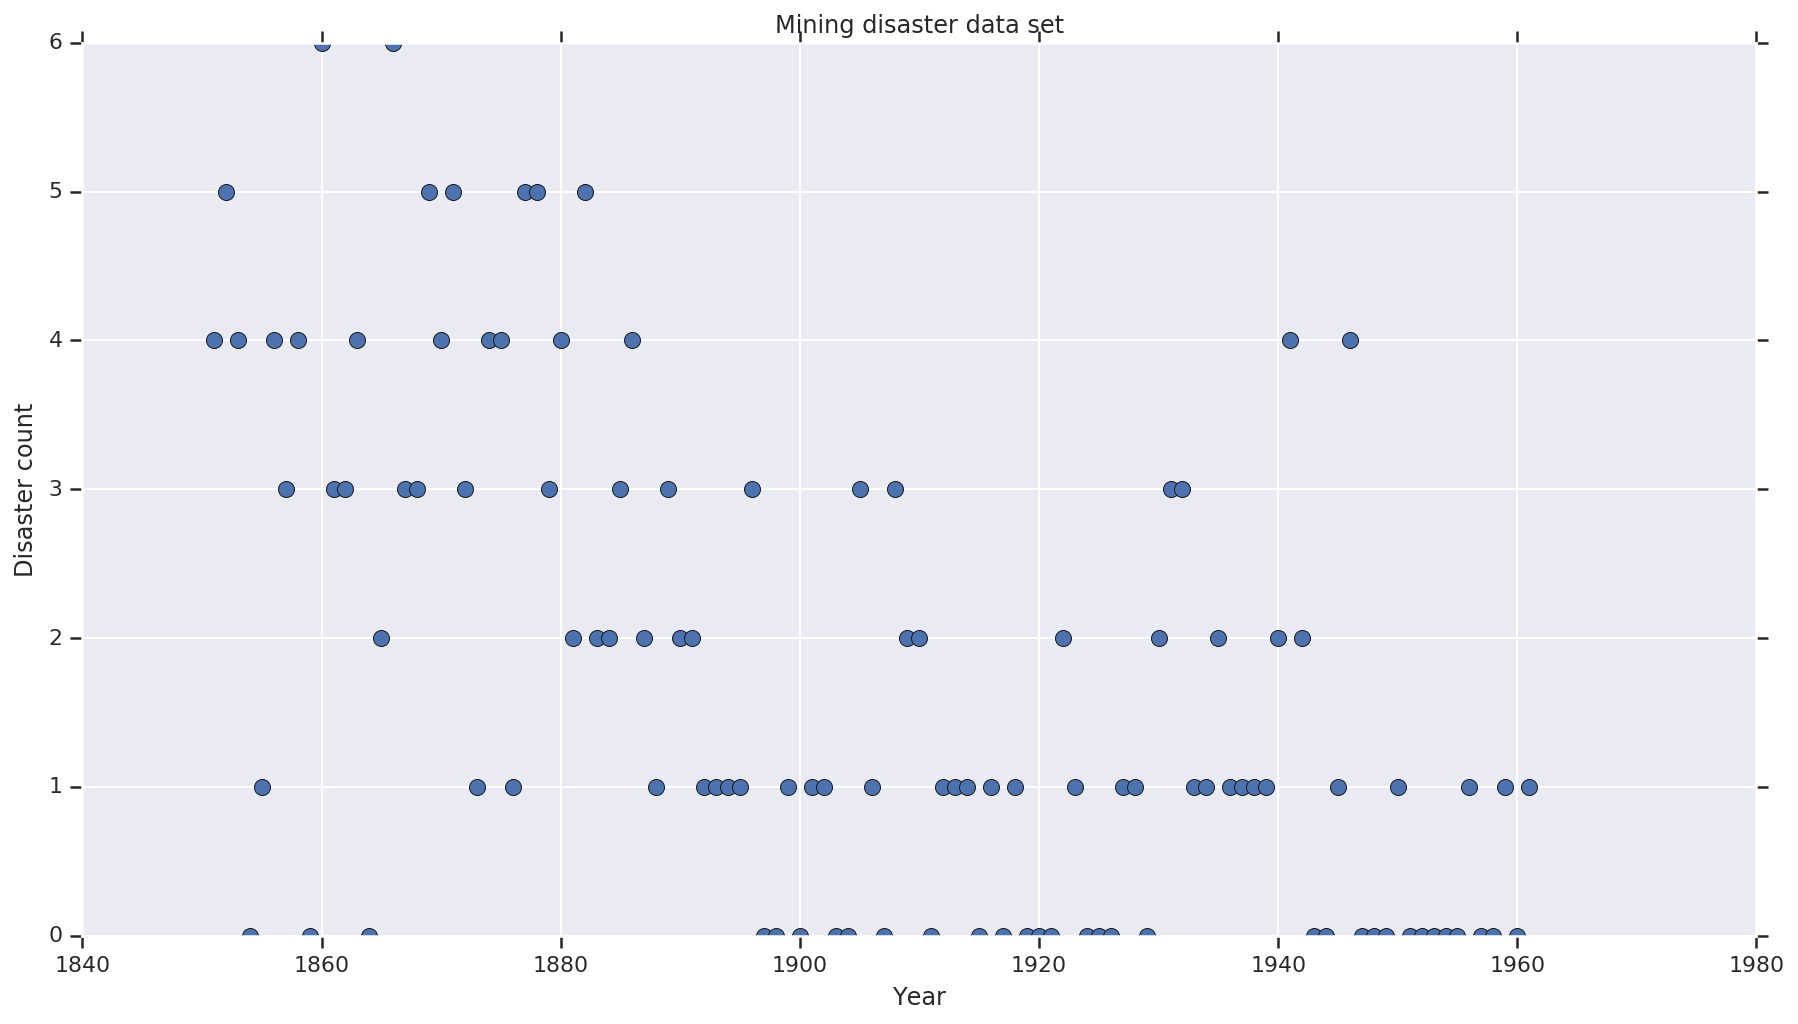

In [ ]:
disaster_data = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)
plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel('Disaster count')
plt.xlabel('Year')
plt.title('Mining disaster data set')
plt.show()

## 확률 모델

이 모델은 '변환점'(예: 안전 규정이 변경된 1년)과 해당 변환점 전후에 일정한(그렇지만 잠재적으로 다른) 비율로 포아송 분포 재해율을 가정합니다.

실제 재해 수는 고정되어 있습니다(관찰됨). 이 모델의 모든 샘플은 재난의 변환점과 '초기' 및 '후기' 비율을 모두 지정해야 합니다.

[pymc3 설명서 예제](https://pymc-devs.github.io/pymc/tutorial.html)의 원본 모델은 다음과 같습니다.

$$ \begin{align*} (D_t|s,e,l)&\sim \text{Poisson}(r_t), \ & ,\quad\text{with}; r_t = \begin{cases}e & \text{if}; t < s\l &\text{if}; t \ge s\end{cases} \ s&\sim\text{Discrete Uniform}(t_l,,t_h) \ e&\sim\text{Exponential}(r_e)\ l&\sim\text{Exponential}(r_l) \end{align*} $$

그렇지만 평균 재해율 $r_t$는 변환점 $s$에서 불연속성을 가지므로 구별할 수 없습니다. 따라서 해밀턴 몬테카를로(HMC) 알고리즘에 그래디언트 신호를 제공하지 않지만 $s$ 사전 확률이 연속적이므로, HMC의 임의 행로의 대체는 이 예에서 확률 질량이 높은 영역을 찾기에 충분합니다.

두 번째 모델로 *e*와 *l* 간의 [시그모이드 '변환'](https://en.wikipedia.org/wiki/Sigmoid_function)으로 원본 모델을 수정하여 전환을 미분할 수 있도록 하고, 변환점 $s$에 대한 연속 균등 분포를 사용합니다(평균 속도의 '변환'이 여러 해에 걸쳐 확장될 가능성이 있어서 이 모델이 더 실제에 가깝다고 주장할 수 있습니다). 따라서 새 모델은 다음과 같습니다.

$$ \begin{align*} (D_t|s,e,l)&\sim\text{Poisson}(r_t), \ & ,\quad \text{with}; r_t = e + \frac{1}{1+\exp(s-t)}(l-e) \ s&\sim\text{Uniform}(t_l,,t_h) \ e&\sim\text{Exponential}(r_e)\ l&\sim\text{Exponential}(r_l) \end{align*} $$

추가 정보가 없는 경우 $r_e = r_l = 1$을 사전 확률에 대한 매개변수로 가정합니다. 두 모델을 모두 실행하고 추론 결과를 비교합니다.

In [ ]:
def disaster_count_model(disaster_rate_fn):
  disaster_count = tfd.JointDistributionNamed(dict(
    e=tfd.Exponential(rate=1.),
    l=tfd.Exponential(rate=1.),
    s=tfd.Uniform(0., high=len(years)),
    d_t=lambda s, l, e: tfd.Independent(
        tfd.Poisson(rate=disaster_rate_fn(np.arange(len(years)), s, l, e)),
        reinterpreted_batch_ndims=1)
  ))
  return disaster_count

def disaster_rate_switch(ys, s, l, e):
  return tf.where(ys &lt; s, e, l)

def disaster_rate_sigmoid(ys, s, l, e):
  return e + tf.sigmoid(ys - s) * (l - e)

model_switch = disaster_count_model(disaster_rate_switch)
model_sigmoid = disaster_count_model(disaster_rate_sigmoid)

위의 코드는 JointDistributionSequential 분포를 통해 모델을 정의합니다. `disaster_rate` 함수는 `[0, ..., len(years)-1]`의 배열로 호출되어 `len(years)` 확률 변수의 벡터를 생성합니다. `switchpoint` 이전의 연도는 `early_disaster_rate`이고, 이후의 연도는 `late_disaster_rate`입니다(시그모이드 전환에 대해 modulo 연산 수행).

다음은 대상 로그 확률 함수가 정상인지 확인하는 온전성 검사입니다.

In [ ]:
def target_log_prob_fn(model, s, e, l):
  return model.log_prob(s=s, e=e, l=l, d_t=disaster_data)

models = [model_switch, model_sigmoid]
print([target_log_prob_fn(m, 40., 3., .9).numpy() for m in models])  # Somewhat likely result
print([target_log_prob_fn(m, 60., 1., 5.).numpy() for m in models])  # Rather unlikely result
print([target_log_prob_fn(m, -10., 1., 1.).numpy() for m in models]) # Impossible result

[-176.94559, -176.28717]
[-371.3125, -366.8816]
[-inf, -inf]


## 베이지안 추론을 수행하는 HMC

필요한 결과 수와 burn-in 스텝을 정의합니다. 코드는 대부분 [tfp.mcmc.HamiltonianMonteCarlo의 설명서](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo)를 모델로 합니다. 코드는 적응형 스텝 크기를 사용합니다(그렇지 않으면 도출된 결과가 선택한 스텝 크기 값에 매우 민감함). chain의 초기 상태로 1의 값을 사용합니다.

위의 내용만이 전부는 아닙니다. 위의 모델 정의로 돌아가면 일부 확률 분포가 실정수 선에서 잘 정의되지 않았음을 알 수 있습니다. 따라서 HMC 커널을 확률 분포가 정의된 도메인으로 실수를 변환하기 위해 순방향 bijector를 지정하는 [TransformedTransitionKernel](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/TransformedTransitionKernel)로 래핑하여 HMC가 검사할 공간을 제약합니다(아래 코드의 코멘트를 참조하세요).

In [ ]:
num_results = 10000
num_burnin_steps = 3000

@tf.function(autograph=False, experimental_compile=True)
def make_chain(target_log_prob_fn):
   kernel = tfp.mcmc.TransformedTransitionKernel(
       inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=target_log_prob_fn,
          step_size=0.05,
          num_leapfrog_steps=3),
       bijector=[
          # The switchpoint is constrained between zero and len(years).
          # Hence we supply a bijector that maps the real numbers (in a
          # differentiable way) to the interval (0;len(yers))
          tfb.Sigmoid(low=0., high=tf.cast(len(years), dtype=tf.float32)),
          # Early and late disaster rate: The exponential distribution is
          # defined on the positive real numbers
          tfb.Softplus(),
          tfb.Softplus(),
      ])
   kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8*num_burnin_steps))

   states = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          # The three latent variables
          tf.ones([], name='init_switchpoint'),
          tf.ones([], name='init_early_disaster_rate'),
          tf.ones([], name='init_late_disaster_rate'),
      ],
      trace_fn=None,
      kernel=kernel)
   return states

switch_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_switch, *args))]
sigmoid_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_sigmoid, *args))]

switchpoint, early_disaster_rate, late_disaster_rate = zip(
    switch_samples, sigmoid_samples)

두 모델을 병렬로 실행합니다.

## 결과 시각화하기

결과를 초기 및 후기 재해율과, 변환점에 대한 사후 확률 분포 샘플의 히스토그램으로 시각화합니다. 히스토그램은 샘플 중앙값을 나타내는 실선과 95% 신뢰할 수 있는 구간 경계를 나타내는 점선으로 표시됩니다.

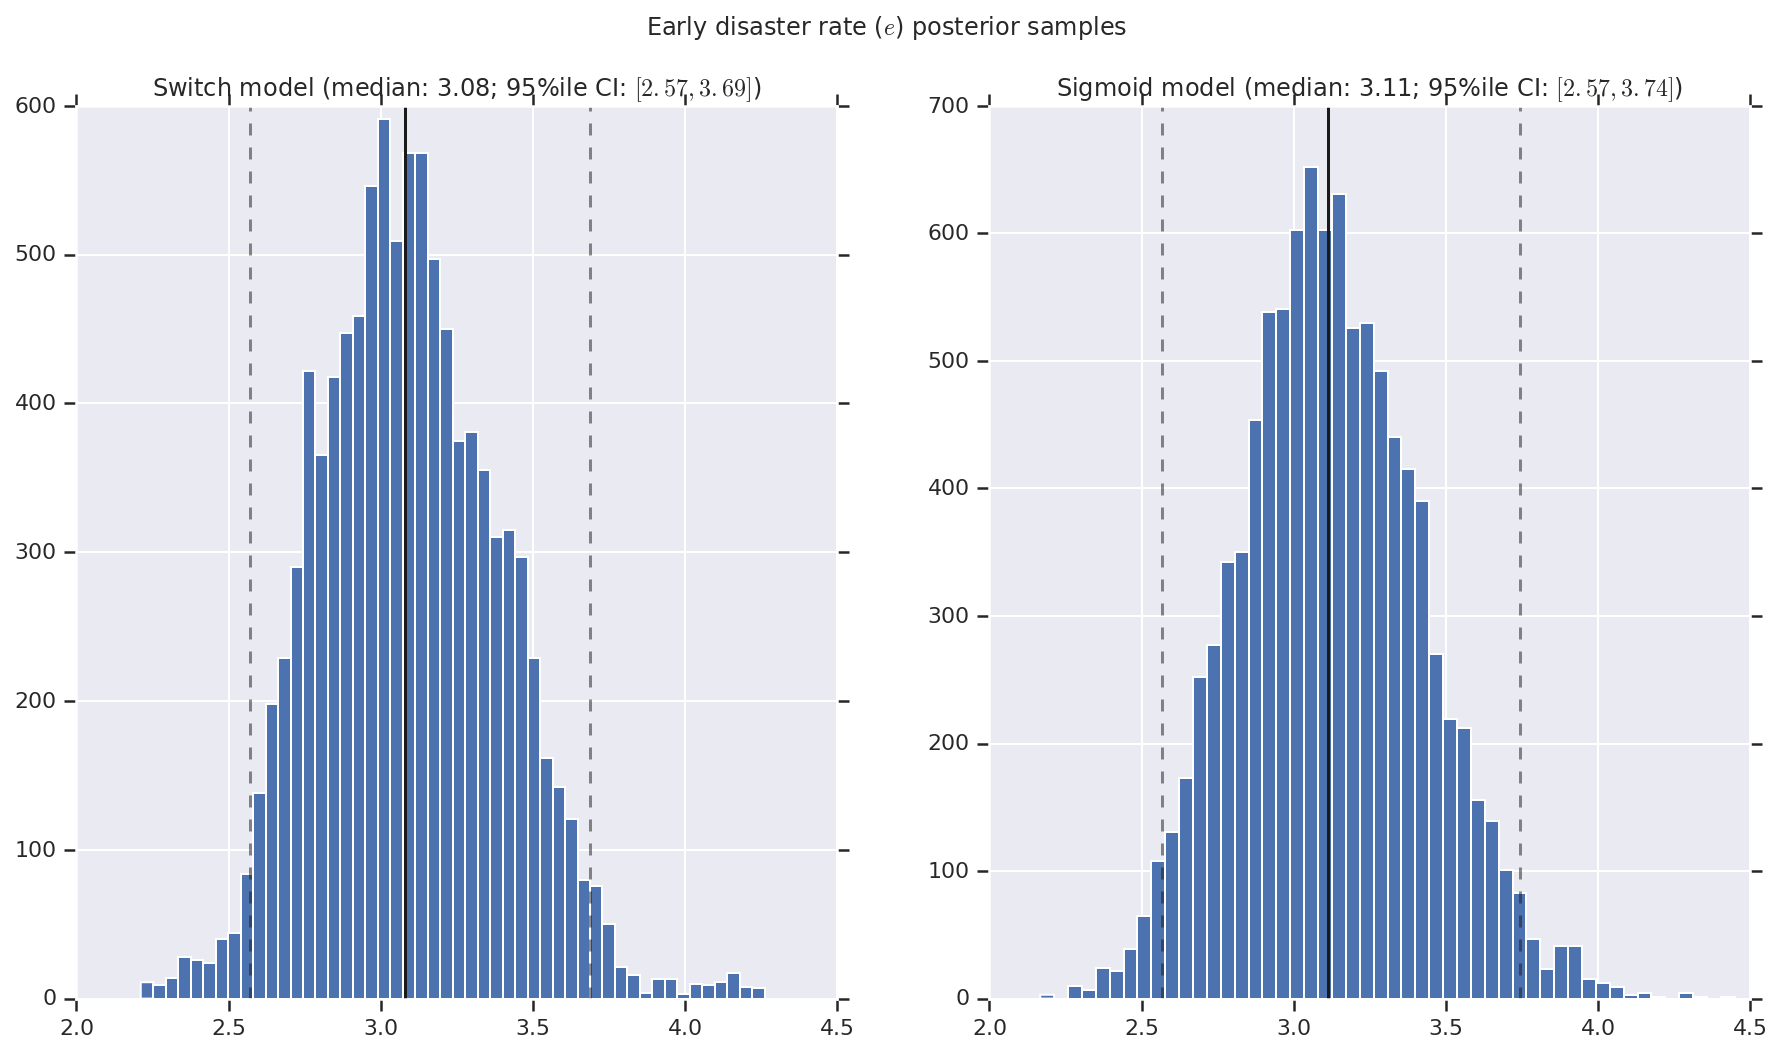

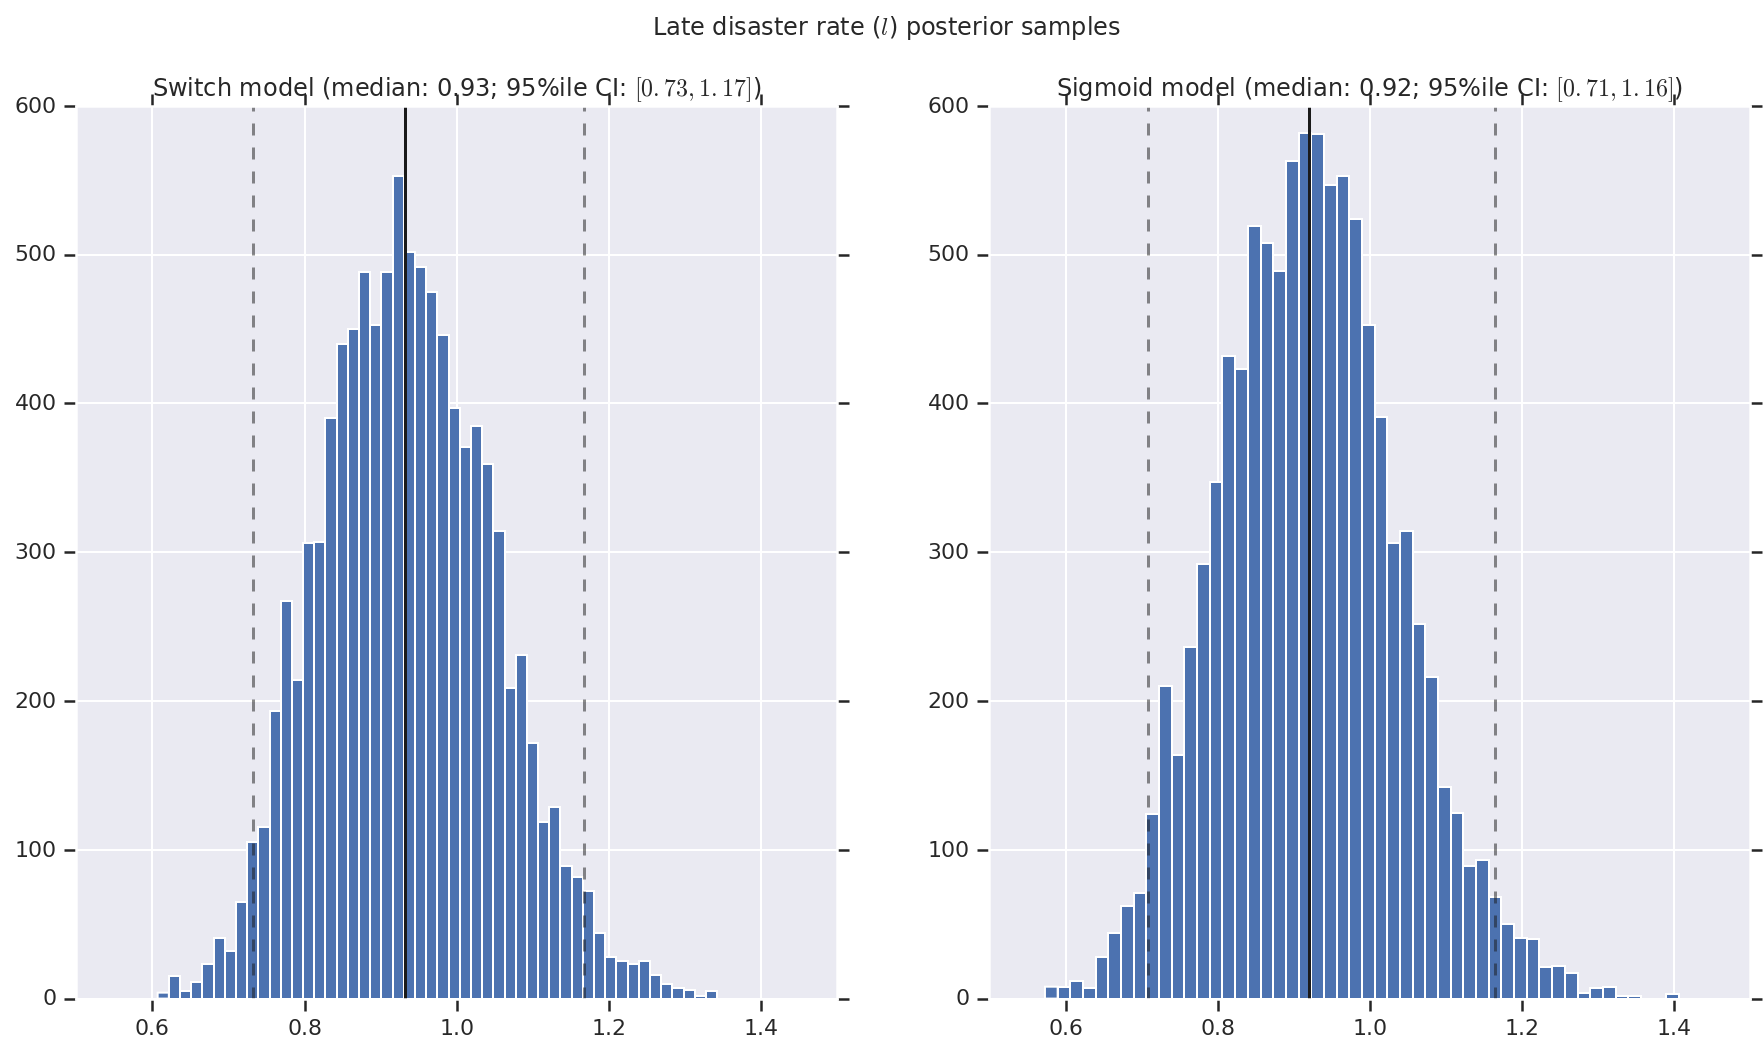

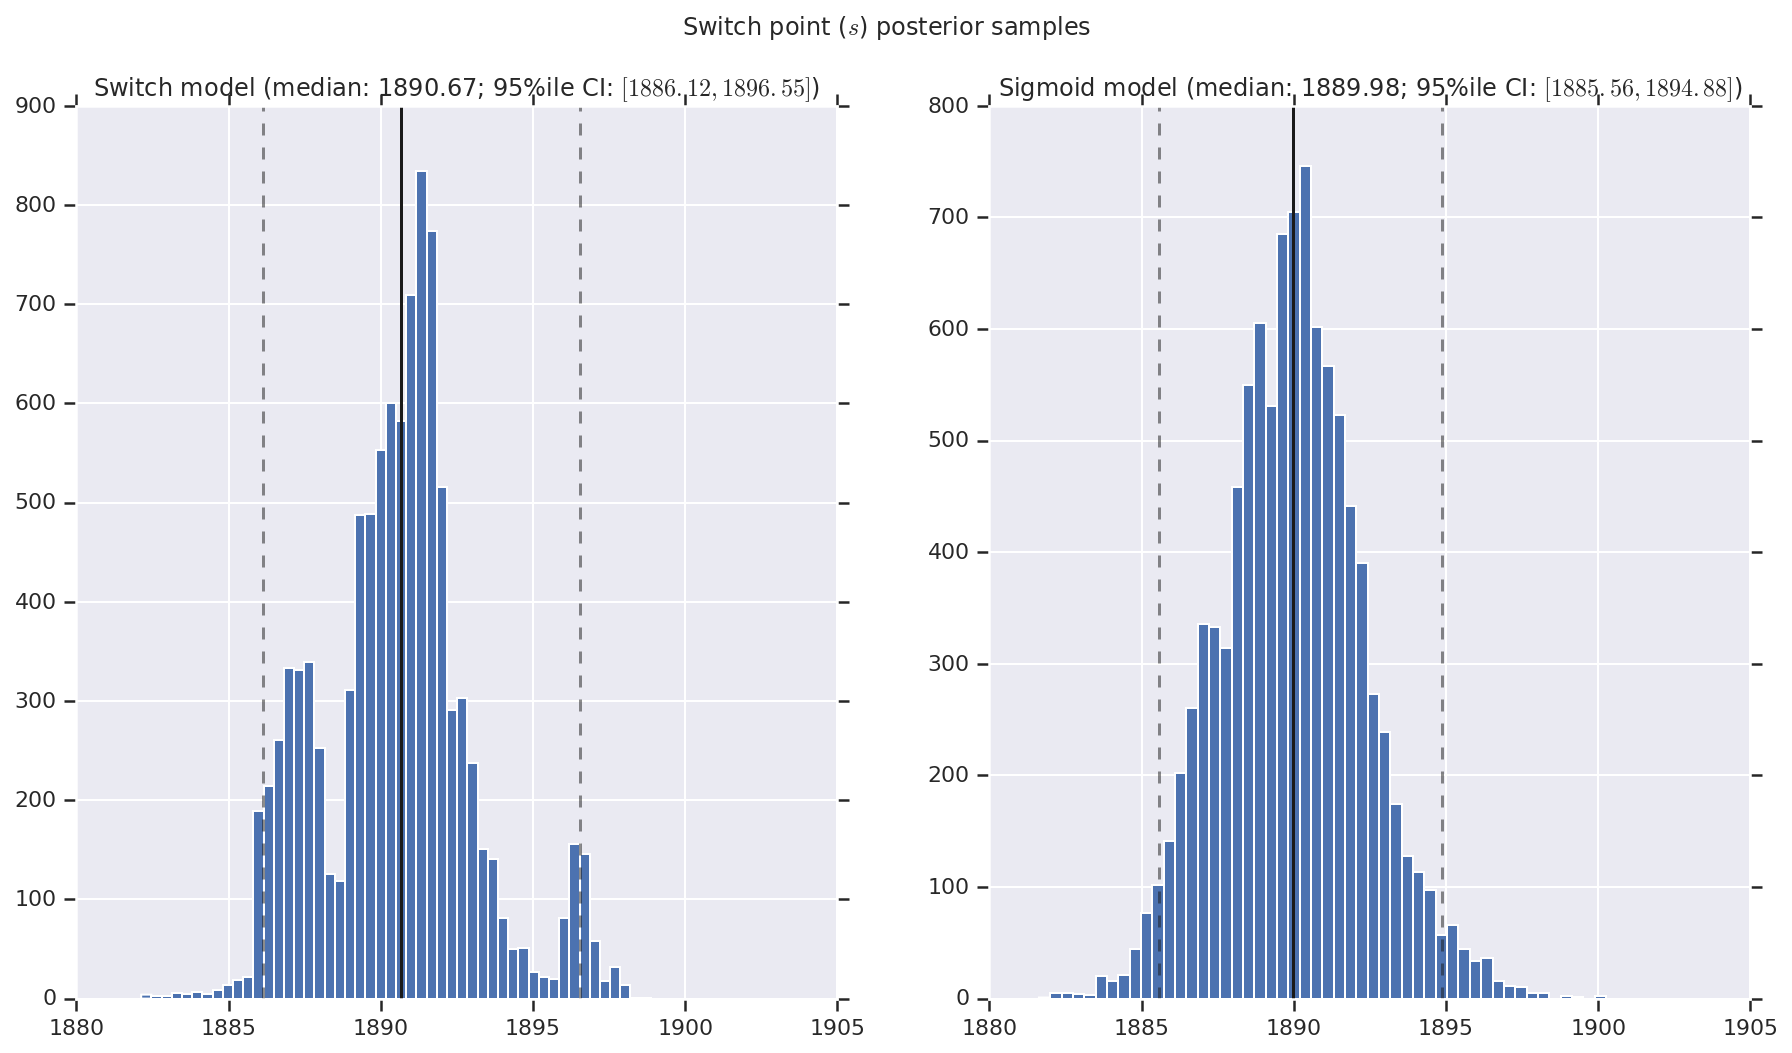

In [ ]:
def _desc(v):
  return '(median: {}; 95%ile CI: $[{}, {}]$)'.format(
      *np.round(np.percentile(v, [50, 2.5, 97.5]), 2))

for t, v in [
    ('Early disaster rate ($e$) posterior samples', early_disaster_rate),
    ('Late disaster rate ($l$) posterior samples', late_disaster_rate),
    ('Switch point ($s$) posterior samples', years[0] + switchpoint),
]:
  fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
  for (m, i) in (('Switch', 0), ('Sigmoid', 1)):
    a = ax[i]
    a.hist(v[i], bins=50)
    a.axvline(x=np.percentile(v[i], 50), color='k')
    a.axvline(x=np.percentile(v[i], 2.5), color='k', ls='dashed', alpha=.5)
    a.axvline(x=np.percentile(v[i], 97.5), color='k', ls='dashed', alpha=.5)
    a.set_title(m + ' model ' + _desc(v[i]))
  fig.suptitle(t)
  plt.show()